In [1]:
import skcriteria as skc
from skcriteria import pipeline
from skcriteria.preprocessing import invert_objectives, weighters, scalers
from skcriteria.madm import similarity, moora, electre

import matplotlib.pyplot as plt
import seaborn as sns


import garpar as gp 
import pandas as pd 
import numpy as np
import itertools as it


In [3]:
wfci = pd.read_csv("/home/nadia/Dropbox/tesis doctoral 2/datosFCI_sin_cedears.csv")
wfci.columns = wfci.columns.str.strip()
wfci["Fondo"] = [
    "Galicia", 
    "BNA",
    "MACRO",
    "Credicoop",
    "ICBC",
    "Comafi",
    "HSBC",
    "Patagonia",
    "Mariva",
    "Supervielle",
    "Santander",
    "Bs.As.",
    "Val.Allaria",
    "Val.Arpenta",
    "Val.Bull",
    "Val.SBS",
    "Val.Valiant"]
    

In [4]:
wfci.Fondo

0         Galicia
1             BNA
2           MACRO
3       Credicoop
4            ICBC
5          Comafi
6            HSBC
7       Patagonia
8          Mariva
9     Supervielle
10      Santander
11         Bs.As.
12    Val.Allaria
13    Val.Arpenta
14       Val.Bull
15        Val.SBS
16    Val.Valiant
Name: Fondo, dtype: object

se toma un año de la cartera al considerar el horizonte temporar de la inersión. 
Se recomienda tomar un año en optimización de carteras para estimar los retornos.

In [5]:
mervalf = gp.datasets.load_MERVAL(first="29-07-2021", 
                                  last = "29-07-2022")
mervalf

Stocks,ALUA[⚖ 0.019231],BBAR[⚖ 0.019231],BYMA[⚖ 0.019231],CEPU[⚖ 0.019231],COME[⚖ 0.019231],CRES[⚖ 0.019231],CVH[⚖ 0.019231],EDN[⚖ 0.019231],GGAL[⚖ 0.019231],HARG[⚖ 0.019231],...,MOLA[⚖ 0.019231],MOLI[⚖ 0.019231],MORI[⚖ 0.019231],OEST[⚖ 0.019231],PATA[⚖ 0.019231],POLL[⚖ 0.019231],RIGO[⚖ 0.019231],SAMI[⚖ 0.019231],SEMI[⚖ 0.019231],TGLT[⚖ 0.019231]
Days,,,,,,,,,,,,,,,,,,,,,
2021-07-29,60.40,193.25,780.00,45.00,4.40,115.50,345.0,39.85,147.60,178.00,...,934.0,87.30,15.55,39.5,32.4,13.0,149.5,118.75,5.50,3.87
2021-07-30,60.30,188.80,780.00,44.65,4.33,112.25,339.0,39.00,142.55,176.00,...,894.0,85.40,15.45,39.5,32.2,15.0,149.0,117.75,5.45,3.80
2021-08-02,61.50,186.25,785.00,45.85,4.50,114.55,333.5,40.30,142.35,179.50,...,877.0,85.60,15.05,39.3,32.0,14.9,147.0,119.75,5.55,3.90
2021-08-03,61.10,185.00,790.00,44.65,4.50,111.70,332.0,41.00,145.60,179.25,...,957.0,88.00,15.20,39.0,32.0,14.9,147.0,120.00,5.55,3.80
2021-08-04,59.80,183.65,790.00,42.55,4.60,110.35,329.5,39.85,143.55,180.50,...,1030.0,88.70,15.00,36.5,32.1,14.8,147.0,122.00,5.40,3.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-25,144.75,251.85,204.50,104.10,15.75,164.90,686.0,75.60,214.35,194.50,...,2447.0,156.00,16.75,60.0,57.8,28.5,250.0,141.25,9.00,4.46
2022-07-26,139.50,257.75,205.50,106.30,15.30,174.90,700.5,75.90,214.50,201.00,...,2412.0,155.00,16.80,62.0,57.0,29.0,250.0,137.50,8.94,4.45
2022-07-27,146.50,274.85,222.00,117.55,16.25,183.50,707.5,79.00,225.65,210.00,...,2399.5,158.50,17.55,65.0,59.5,30.0,260.0,142.00,9.28,4.53


In [6]:
def asignw(nfondo):
    fondo = wfci[wfci["Fondo"]== nfondo]
    weights = []
    for stock in mervalf.stocks:
        try:
            w = float(fondo[stock].values[0].replace(",","."))
        except KeyError:
            w = 0.
        weights.append(w)

    nm = mervalf.copy(weights=weights,title=nfondo).scale_weights()
    return nm

def get_metrics(nfondo):
    mopt = asignw(nfondo).dprune().wprune().scale_weights()
    metrics = {
        "Fondo": nfondo,
       # "entropy": entropy,
        "stocks_seleccionados": len(mopt.stocks),
        "beta_portafolio": mopt.risk.pf_beta(),
        "varianza_portafolio": mopt.risk.pf_var(),
        "VaR_portafolio": np.sum(mopt.risk.value() * mopt.weights),
        "Sharpe_Ratio": mopt.risk.sharpe(),
        "Treynor_Ratio": mopt.risk.treynor_ratio(),
        "Entropia_cruzada": mopt.div.cross_entropy(),
        "Entropia_KeyZang": mopt.div.ke_zang_entropy(),
        "Entropia_Zheng": mopt.div.zheng_entropy(),
        #"Delta_diversific": mopt.div.delta(),
        "Ratio_diversific": mopt.div.ratio(),
        "CV_Contribuciones_marginales":(mopt.div.mrc() *  mopt.weights).std() / (mopt.div.mrc() *  mopt.weights).mean(),
        "Indice_diversific_port": mopt.div.pdi(n_components=5, random_state=100),
    }
    return metrics
    

In [7]:
translate = {
        "stocks_seleccionados": "Selected stocks",
       }

## Calculo de métricas

aca hago zaraza del zaraza

$u_9 = 23$

In [8]:
rows = []
for nfondo in wfci.Fondo:
    metrics = get_metrics(nfondo)
    rows.append(metrics)
metrics = pd.DataFrame(rows)
metrics.set_index("Fondo", inplace=True, drop=True)
metrics

,stocks_seleccionados,beta_portafolio,varianza_portafolio,VaR_portafolio,Sharpe_Ratio,Treynor_Ratio,Entropia_cruzada,Entropia_KeyZang,Entropia_Zheng,Ratio_diversific,CV_Contribuciones_marginales,Indice_diversific_port
Fondo,,,,,,,,,,,,
Galicia,27,1.673191,0.106095,0.040332,-3.237707,-0.642242,1.026304,2.754291,2.648196,0.094987,1.352807,1.356961
BNA,19,1.305662,0.107886,0.040073,-2.825605,-0.726144,0.514198,2.696622,2.588735,0.093679,0.963059,1.708972
MACRO,19,1.704964,0.112052,0.040180,-2.813989,-0.564210,0.778968,2.470591,2.358540,0.092209,1.225660,1.689137
Credicoop,18,1.354701,0.102477,0.039187,-2.891776,-0.698101,0.454785,2.710788,2.608311,0.096451,0.810086,1.673447
ICBC,26,1.468175,0.088988,0.038297,-3.360620,-0.696445,0.678679,2.903753,2.814764,0.102112,1.055144,1.381591
Comafi,7,0.976238,0.119388,0.040135,-2.818415,-1.018025,0.192727,1.906383,1.786995,0.081438,0.506193,3.650204
HSBC,24,1.876506,0.104736,0.039604,-3.210461,-0.564347,1.009999,2.677716,2.572979,0.096354,1.240999,1.369945
Patagonia,16,0.920309,0.115454,0.040872,-2.812602,-1.060166,0.386546,2.556743,2.441289,0.089836,0.925144,1.914891
Mariva,15,1.463561,0.111366,0.040206,-2.223565,-0.520673,0.729467,2.316669,2.205304,0.096718,1.041671,1.936375


In [9]:
metrics.describe()

,stocks_seleccionados,beta_portafolio,varianza_portafolio,VaR_portafolio,Sharpe_Ratio,Treynor_Ratio,Entropia_cruzada,Entropia_KeyZang,Entropia_Zheng,Ratio_diversific,CV_Contribuciones_marginales,Indice_diversific_port
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,16.411765,1.339938,0.110256,0.039950,-2.858527,-0.774210,0.567449,2.459759,2.349503,0.093555,0.959161,1.951765
std,6.103880,0.338658,0.008403,0.000715,0.341308,0.239994,0.378853,0.265680,0.271188,0.005564,0.264844,0.581681
min,7.000000,0.920309,0.088988,0.038297,-3.447793,-1.277967,0.065626,1.906383,1.786995,0.081438,0.506193,1.356961
25%,11.000000,0.988322,0.104736,0.039446,-3.015587,-1.006628,0.295975,2.308201,2.189832,0.091985,0.703042,1.689137
50%,18.000000,1.354701,0.110189,0.040135,-2.825605,-0.698101,0.454785,2.472599,2.358540,0.093679,0.963059,1.768526
75%,19.000000,1.614809,0.117246,0.040332,-2.812602,-0.564347,0.778968,2.677716,2.572979,0.096451,1.225660,2.073541
max,27.000000,1.914415,0.124626,0.040909,-2.223565,-0.400044,1.297474,2.903753,2.814764,0.102112,1.352807,3.650204


In [10]:
metrics.skew(axis = 0, skipna = None, level = None, numeric_only = None)

stocks_seleccionados            0.054642
beta_portafolio                 0.255880
varianza_portafolio            -0.659074
VaR_portafolio                 -0.773354
Sharpe_Ratio                    0.207153
Treynor_Ratio                  -0.459235
Entropia_cruzada                0.511202
Entropia_KeyZang               -0.388892
Entropia_Zheng                 -0.343898
Ratio_diversific               -0.372444
CV_Contribuciones_marginales   -0.065652
Indice_diversific_port          1.865355
dtype: float64

In [22]:
metrics.kurt(axis=0, skipna=True, level=None, numeric_only=None)

stocks_seleccionados           -0.751806
beta_portafolio                -1.258173
varianza_portafolio             1.314480
VaR_portafolio                  0.244370
Sharpe_Ratio                    0.011920
Treynor_Ratio                  -0.578919
Entropia_cruzada               -0.821514
Entropia_KeyZang               -0.372987
Entropia_Zheng                 -0.359338
Ratio_diversific                0.197386
CV_Contribuciones_marginales   -1.124959
Indice_diversific_port          3.972555
dtype: float64

<AxesSubplot:>

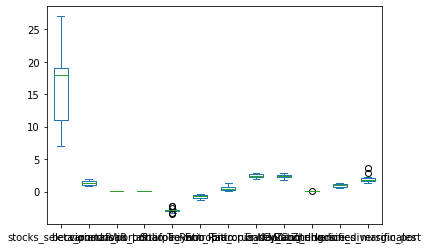

In [24]:
metrics.plot.box()

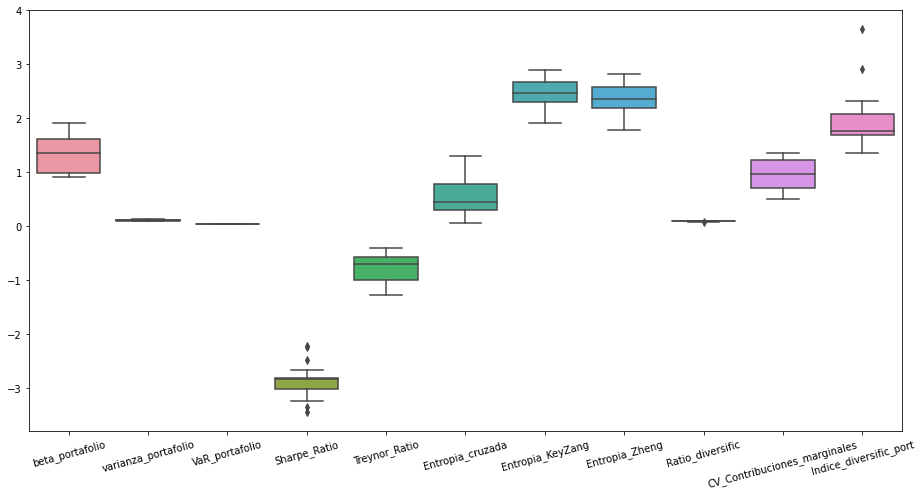

In [43]:

fig, ax = plt.subplots(figsize=(13,7))
#metrics.plot.box(ax=ax, color="g")
sns.boxplot(data=metrics[metrics.columns[1:]], ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 15)
fig.tight_layout()
plt.savefig("cajasinnormalizar.pdf")
# excluye el criterio del conteo porque sino las cajas quedan un moco

<AxesSubplot:xlabel='Fondo'>

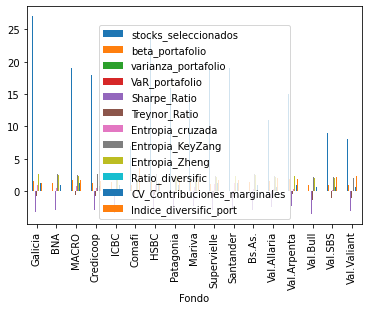

In [56]:
metrics.plot.bar()
#fig, ax = plt.subplots(figsize=(13,7))
#metrics.plot("heatmap", ax=ax, cbar=False, cmap="Greys")
#ax.set_xticklabels(ax.get_xticklabels(), rotation = 15)
#fig.tight_layout()

In [25]:
objectives = [
    max, #     'stocks_seleccionados', coincide con definición mayor número de stocks
    min, #     'beta_portafolio', ver estaría bueno fuera cercana a 1 a màs o menos pronbunciada que el mercado. Ver RIM 
    min, #     'varianza_portafolio',
    min, #     'VaR_portafolio', es el valor promedio ponderado que asigna una probabilidad del 5% a tener pérdida, se busca lo más bajo posible para que pequeños movimientos no afecten  
    max, #     'Sharpe_Ratio', es el exceso de rendimiento sobre la tasa libre de riesgo en relación a la variabilidad, busco maximizar porque denominador debe hacerse más pequeño y numerador más grande 
    max, #     'Treynor_Ratio', mide el rendimiento en relación al Beta_i
    min, #     'Entropia_cruzada', mide el desorden al compararlo con una estrategia teórica de riski part equall
    min, #     'Entropia_KeyZang', considera una medida de eentropía y variabilidad
    min, #     'Entropia_Zheng', 
    max, #     'Ratio_diversific', mide la diversificación ganada por  mantener activos no correlacionados
    min, #     'CV_Contribuciones_marginales', si todos los activos tienen igual contribución marginal es un portfolio diversificado
    max, #     'Indice_diversific_port, si hay correlacióan alta el índice dará un valor bajo mientras que si no hay correlación el índice tenderá al valor N
]

dm = skc.mkdm(metrics.to_numpy(), objectives, alternatives=metrics.index, criteria=metrics.columns)

In [26]:
pipe = pipeline.mkpipe(
    invert_objectives.NegateMinimize(),
    #scalers.SumScaler(target="weights"),
    scalers.SumScaler(target="matrix"),
    weighters.Critic(),
    similarity.TOPSIS(),
)
pipe

SKCPipeline(steps=[('negateminimize', NegateMinimize()), ('sumscaler', SumScaler(target='matrix')), ('critic', Critic(correlation=<function pearson_correlation at 0x7fcbaed9a790>, scale=True)), ('topsis', TOPSIS(metric='euclidean'))])

In [27]:
result = pipe.evaluate(dm)
result

,Galicia,BNA,MACRO,Credicoop,ICBC,Comafi,HSBC,Patagonia,Mariva,Supervielle,Santander,Bs.As.,Val.Allaria,Val.Arpenta,Val.Bull,Val.SBS,Val.Valiant
Rank,3,11,5,13,6,7,4,10,8,2,1,12,17,14,9,15,16


In [28]:
result.e_.similarity

array([0.55205637, 0.3835364 , 0.46874065, 0.34773412, 0.46136856,
       0.41868557, 0.53281144, 0.39146407, 0.41228412, 0.5649925 ,
       0.59934309, 0.35901587, 0.27918637, 0.33833622, 0.41158385,
       0.30929568, 0.30898684])

In [29]:
dmt = pipe.transform(dm)


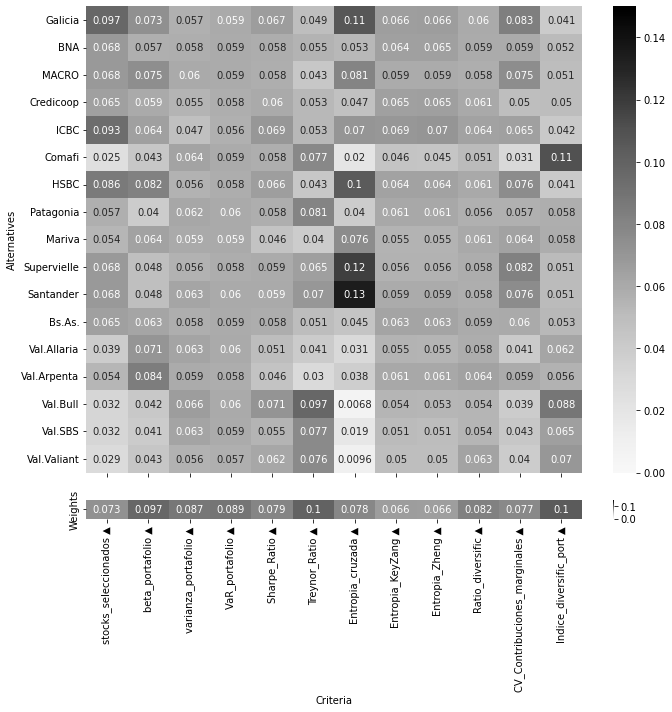

In [107]:
fig, axs = plt.subplots(
    2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [5, .2]})
dmt.plot.heatmap(ax=axs[0], cmap="Greys", vmin=0, vmax=.15, center=0.07)
dmt.plot.wheatmap(ax=axs[1], cmap="Greys", vmin=0, vmax=.15, center=0.07)

axs[0].set_xticklabels([])
axs[0].set_xlabel("")
fig.tight_layout();

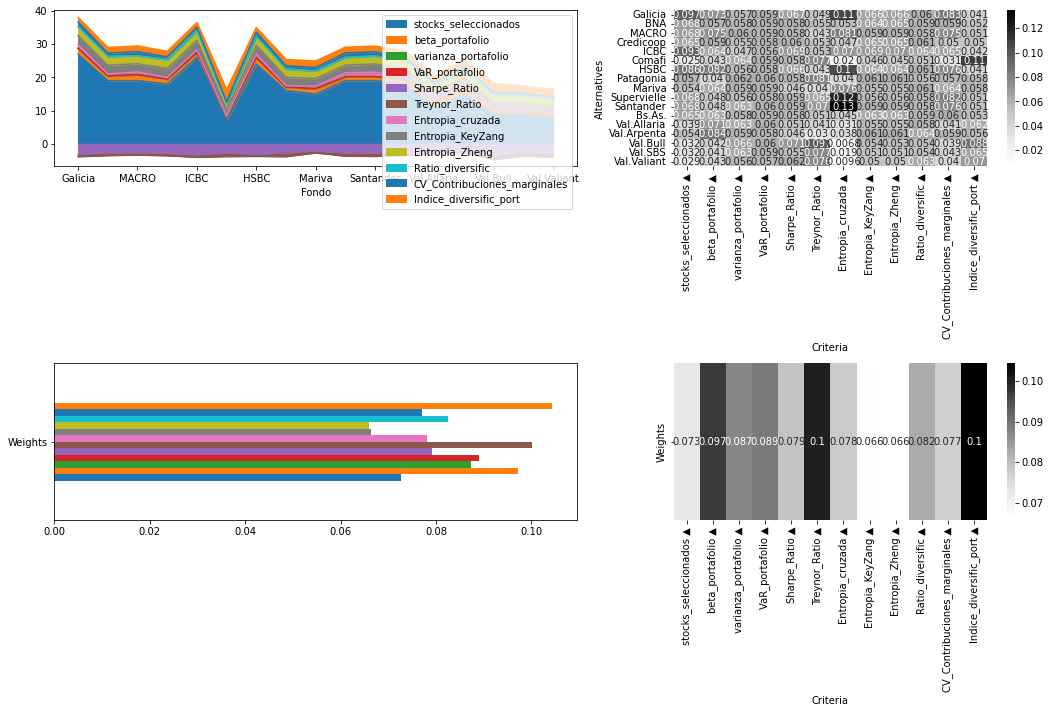

In [91]:
fig, axs = plt.subplots(
    2, 2, figsize=(15, 10), gridspec_kw={'width_ratios': [4, 3], 'height_ratios': [3, 3]})
metrics.plot.area(ax=axs[0,0], legend='upper'); dmt.plot.heatmap(ax=axs[0, 1], cmap="Greys")
dmt.plot.wbarh(ax=axs[1,0], legend=False); dmt.plot.wheatmap(ax=axs[1, 1], cmap="Greys")
fig.tight_layout();



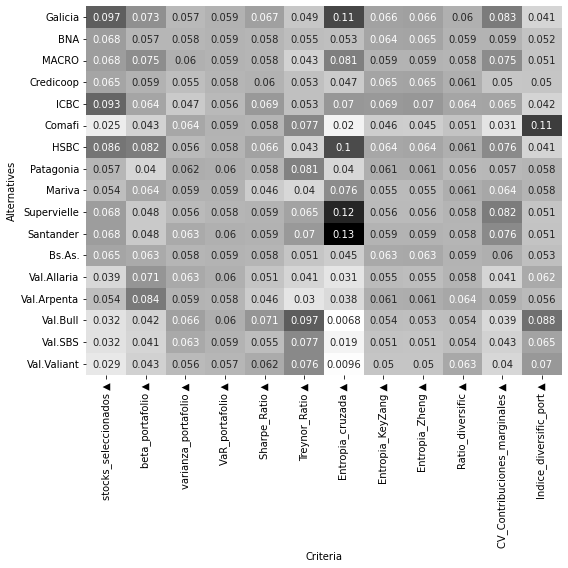

In [49]:
fig, ax = plt.subplots(figsize=(8,8))
dmt.plot(ax=ax, cbar=False, cmap="Greys")
fig.tight_layout()
plt.savefig("Mapadecalo.pdf")

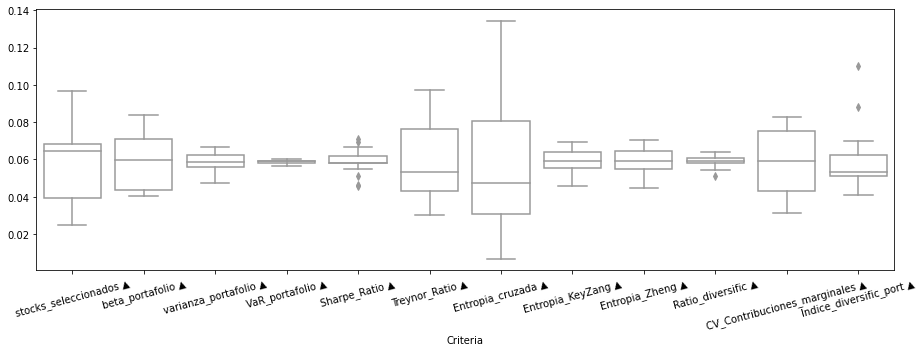

In [31]:
fig, ax = plt.subplots(figsize=(13,5))
dmt.plot.box(ax=ax, color="w")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 15)
fig.tight_layout()
plt.savefig("caja.pdf")

<AxesSubplot:>

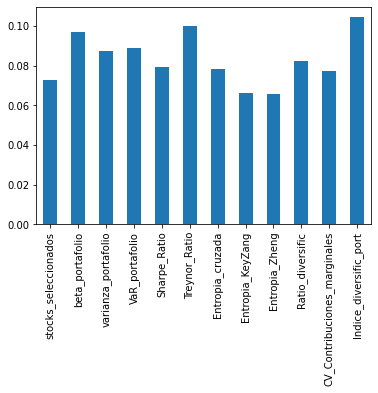

In [45]:
dmt.weights.plot.bar()

<AxesSubplot:ylabel='Frequency'>

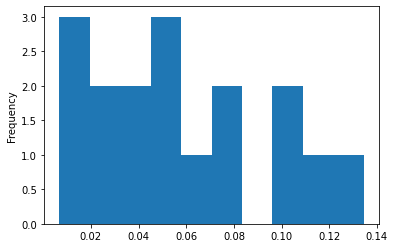

In [46]:
dmt.criteria["Entropia_cruzada"].plot.hist()

<AxesSubplot:ylabel='Proportion'>

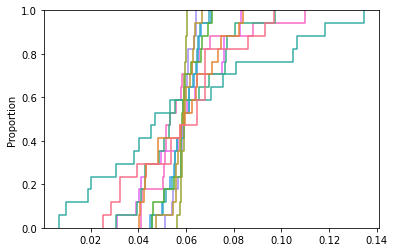

In [47]:
dmt.plot.ogive(legend=False)

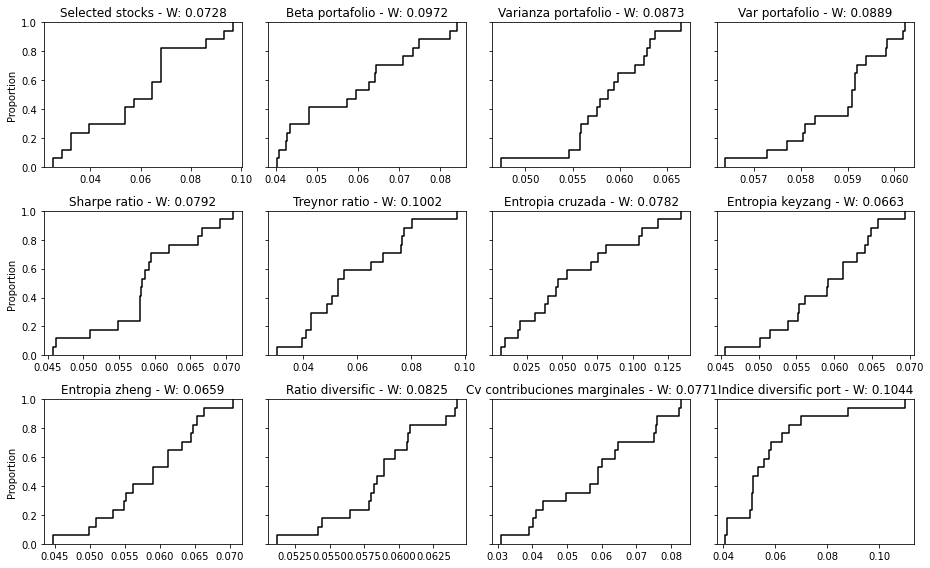

In [48]:
fig, axs = plt.subplots(3,4, sharex=False, sharey=True)
fig.set_size_inches(13,8)
axs = it.chain(*axs)
for crit, wt, ax  in zip(dmt.criteria, dmt.weights, axs):
    valc = dmt.criteria[crit]
    
    sns.ecdfplot(valc, ax=ax, color="k")
    
    ax.set_xlabel("")
    
    title = translate.get(crit, crit)
    title = title.replace("_", " ").capitalize()
    ax.set_title(f"{title} - W: {wt:.4f}")

fig.tight_layout()
plt.savefig("ogive.pdf")

In [ ]:
title.capitalize()

<AxesSubplot:ylabel='Density'>

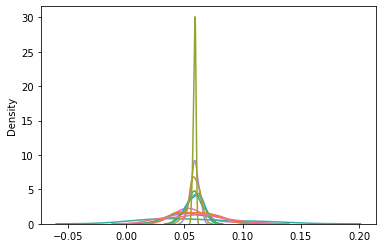

In [72]:
dmt.plot.kde(legend=False)

In [73]:
pipe2 = pipeline.mkpipe(
    invert_objectives.NegateMinimize(),
    #scalers.SumScaler(target="weights"),
    scalers.SumScaler(target="matrix"),
    weighters.EntropyWeighter(),
    similarity.TOPSIS(),
)
pipe2

SKCPipeline(steps=[('negateminimize', NegateMinimize()), ('sumscaler', SumScaler(target='matrix')), ('entropyweighter', EntropyWeighter()), ('topsis', TOPSIS(metric='euclidean'))])

In [74]:
result2 = pipe2.evaluate(dm)
result2

,Galicia,BNA,MACRO,Credicoop,ICBC,Comafi,HSBC,Patagonia,Mariva,Supervielle,Santander,Bs.As.,Val.Allaria,Val.Arpenta,Val.Bull,Val.SBS,Val.Valiant
Rank,2,8,6,11,5,13,4,9,7,3,1,10,17,14,12,15,16


In [75]:
result2.e_.similarity

array([0.60747672, 0.41273783, 0.50404745, 0.37339125, 0.51000407,
       0.36492654, 0.58352435, 0.39147381, 0.43346526, 0.60184382,
       0.63562954, 0.38411591, 0.26986099, 0.34925489, 0.36980396,
       0.28008886, 0.27642892])

In [76]:
dmt2 = pipe2.transform(dm)

<AxesSubplot:>

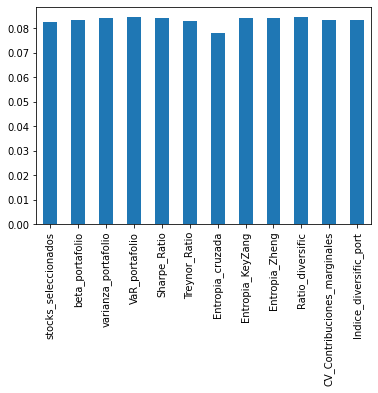

In [77]:
dmt2.weights.plot.bar()